In [51]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import csv
from scipy import signal
import os.path 
from os import listdir
from os.path import isfile, join
from scipy.signal import savgol_filter
import copy

In [52]:
#Funcion que hace una lista de los archivos de una carpeta
def ls(ruta = '.'):
    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]
#correr ls('.')

In [53]:
lista_archivo = ls('.')
lista_archivo

['Analisis-CilCon-Mejorado-2.ipynb',
 'CilCon-0011.csv',
 'CilCon-0012.csv',
 'CilCon-0014.csv',
 'CilCon-0019.csv',
 'CilCon-0021.csv',
 'CilCon-0022.csv',
 'CilCon-0025.csv',
 'CilCon-0026.csv',
 'CilCon-0029.csv',
 'DatosCilCon-2.csv',
 'DatosCilCon-2.xlsx',
 '~$DatosCilCon-2.xlsx']

##### Calibración

In [54]:
Cal = (2.1171+2.1212+2.1079)/3

##### Diccionario

In [63]:
lista_archivo
with open(lista_archivo[10], 'rt') as f:
        reader = csv.reader(f)
        info = list(reader)
        for row in reader:
            print(row)

In [64]:
Lcil = {}
Ltot = {}
Masa = {}
Dmedio = {}

for i in info[1:]:
    Lcil[int(i[0])] = float(i[1])
    Ltot[int(i[0])] = float(i[2])
    Dmedio[int(i[0])] = float(i[3])
    Masa[int(i[0])] = float(i[4])

##### Funciones

In [65]:
def picosy(t,ym,nprc):
    #Cuentas para hallar la velocidad del Ym
    
    #resto recta
    gradient, intercept, r_value, p_value, std_err = stats.linregress(t,ym)
    nuevo = []
    for i,j in zip(t,ym):
        nuevo.append(j-gradient*i-intercept)
    #filtro
    nuevo2 = savgol_filter(nuevo, 51, 3)
    
    peakind = signal.find_peaks_cwt(nuevo2, np.arange(1,10),noise_perc=nprc)
    tpicos=[]
    ypicos=[]
    for j in peakind:
        tpicos.append(t[j])
        ypicos.append(ym[j])
    
    yperiod = []
    for i in range(len(tpicos)-1):
        yperiod.append(tpicos[i+1]-tpicos[i])
    return tpicos, ypicos, np.mean(yperiod)

In [66]:
def picosang(t,Ang,nprc):
    #filtro
    nuevo = savgol_filter(Ang, 51, 3)
    #busco picos
    peakind_Ang = signal.find_peaks_cwt(nuevo, np.arange(1,10),noise_perc=nprc)
    
    Ang_tpicos=[]
    Ang_picos=[]
    for j in peakind_Ang:
        Ang_tpicos.append(t[j])
        Ang_picos.append(Ang[j])

    Periodo_Ang = []
    for i in range(len(Ang_tpicos)-1):
        Periodo_Ang.append(Ang_tpicos[i+1]-Ang_tpicos[i])
    return Ang_tpicos, Ang_picos, np.mean(Periodo_Ang)

In [67]:
def analisis_de_cilindros(archivo,fps,Cal):
    
    with open(archivo, 'rt') as f:
        reader = csv.reader(f)
        data = list(reader)
        for row in reader:
            print(row)
 
    nro = float(archivo[9:11])
    
    tiempo = []
    Xm = []
    Ym = []
    ym = []
    Ang = []
    Angm = []
#     print(data[1][5]/Cal)
    for i in data[1:]:
        tiempo.append(float(i[0])/fps)
        Xm.append(float(i[1])/Cal)#-data[1][5]/Cal)
        Ym.append(float(i[2])/Cal)
        ym.append(-float(i[2])/Cal)
        Ang.append(float(i[5])-90)
        Angm.append(-(float(i[5])-90))
    
    #Calculo de la velocidad de sedimentacion del cilindro al descender verticalmente por la celda (vel de x centro de masa)          
    gradient, intercept, r_value, p_value, std_err = stats.linregress(tiempo,Xm)    

    tpicosM, ypicosM, Periodo_de_YM = picosy(tiempo,Ym,100) #Maximos
    tpicosm, ypicosm, Periodo_de_Ym= picosy(tiempo,ym,100) #Minimos
    ypicosm = -np.asarray(ypicosm)

    Ang_tpicosM, Ang_picosM, T_AngM = picosang(tiempo,Ang,100) #Maximos
    Ang_tpicosm, Ang_picosm, T_Angm = picosang(tiempo,Angm,100) #Minimos
    Ang_picosm = -np.asarray(Ang_picosm)
    
    Periodo_de_Y = (Periodo_de_YM+Periodo_de_Ym)/2
    T_Ang = (T_AngM+T_Angm)/2

    plt.figure(lista_archivo.index(archivo),figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(tiempo,Ym,label = 'Lcil = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(tpicosM,ypicosM,'r*')
    plt.plot(tpicosm,ypicosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,2)
    plt.plot(tiempo,Ang,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(Ang_tpicosM,Ang_picosM,'r*')
    plt.plot(Ang_tpicosm,Ang_picosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,3)
    plt.plot(tiempo,Xm,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.grid(b=True, which='major')
    plt.legend()
    
    LaPapa = [nro,tiempo,Xm,Ym,Ang,tpicosM,ypicosM,tpicosm,ypicosm,Ang_tpicosM,Ang_picosM,Ang_tpicosm,Ang_picosm]
    #ERRORES
    #tiempo
#     errT = 1/fps
    
#     T4 = 0
#     T12 = 0
#     for i in yperiod:
#         T4 = i**(-4)+T4
#     for i in range(len(yperiod)-1):
#         T12 = -2/((yperiod[i]*yperiod[i+1])**2) + T12
#     errfy = (1/fps)*np.sqrt((T4+T12)/len(yperiod)) 
    
#     T4 = 0
#     T12 = 0
#     for i in Periodo_Ang:
#         T4 = i**(-4)+T4
#     for i in range(len(Periodo_Ang)-1):
#         T12 = -2/(Periodo_Ang[i]*Periodo_Ang[i+1]) + T12
#     errfa = (1/fps)*np.sqrt((T4+T12)/len(Periodo_Ang)) 
    
    return nro, gradient, Periodo_de_Y, T_Ang, LaPapa  
#     return L, D, gradient, std_err, Periodo_de_Y, errfy, T_Ang, errfa      

C:\Users\matia\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\matia\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


11.0 -14.948395030623328 0.7142061901580941 0.9005511022044088
12.0 -15.781812141839321 1.0561122244488979 0.9204122530775838
14.0 -13.901547597852373 0.7858216432865732 0.7031234185542803
19.0 -15.213744028966135 0.8057023137183457 0.9019825365015746
21.0 -13.861680354791865 0.5437156364010072 1.3437589464643573
22.0 -15.897738337215994 1.0240480961923848 0.8327766644399912
25.0 -15.889506593381524 1.0604542418169673 0.9893596717244013
26.0 -15.897734847839244 1.1195724782899132 1.0938543754175016
29.0 -11.490204724460046 0.8253173012692051 0.8797595190380761


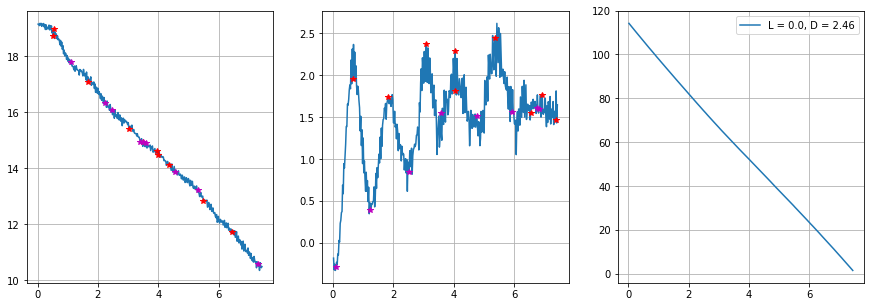

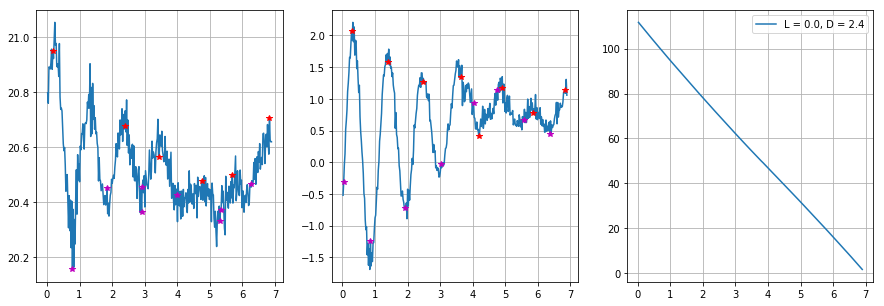

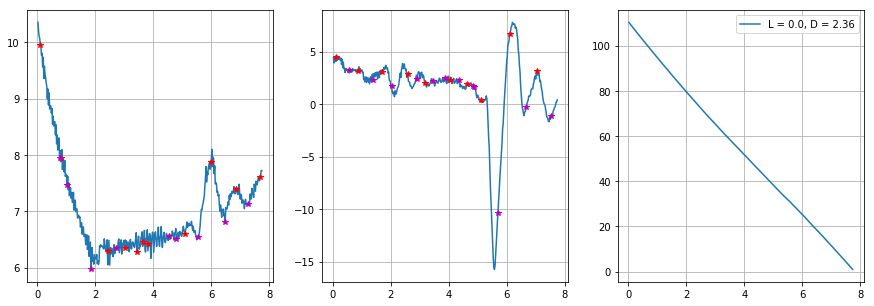

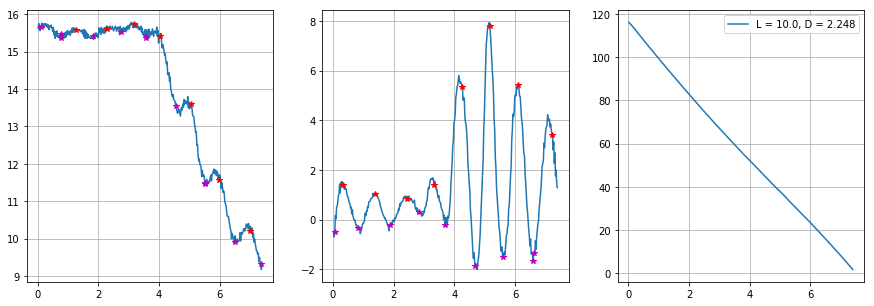

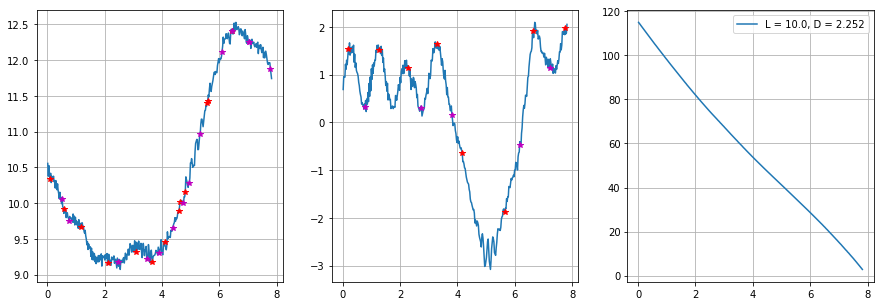

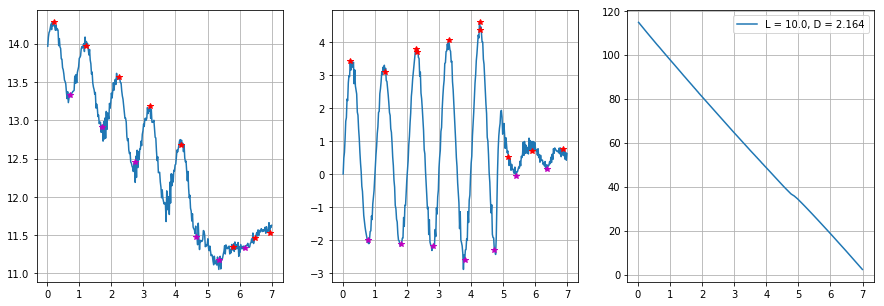

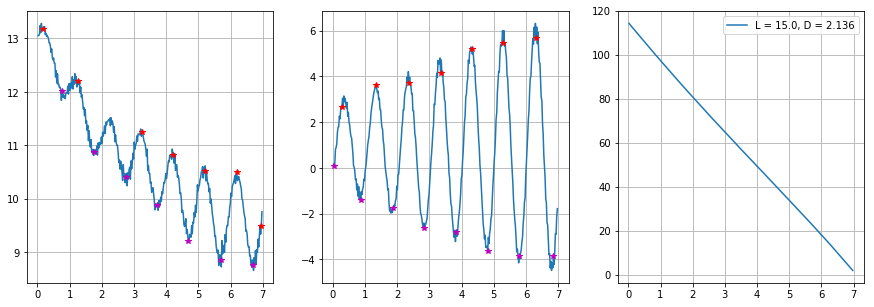

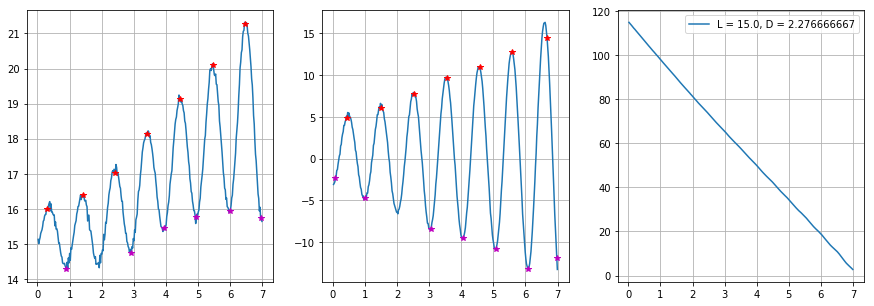

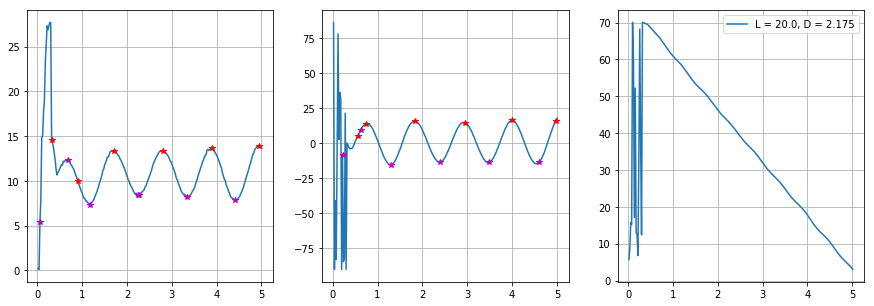

In [45]:
Discretos = []
MaximosY = {}
MinimosY = {}
MaximosA = {}
MinimosA = {}
tMaximosY = {}
tMinimosY = {}
tMaximosA = {}
tMinimosA = {}
Tiempo = {}
YCM = {}
XCM = {}
ANG = {}
VCM = {}
TY = {}
TA = {}
for i in range(1,10):
    nro, Vcm, Ty, Ta, dat = analisis_de_cilindros(lista_archivo[i],49.9,Cal)
    VCM[nro]=Vcm
    print(nro, Vcm, Ty, Ta)
    TY[nro]=Ty
    TA[nro]=Ta
    MaximosY[nro]=dat[6]
    tMaximosY[nro]=dat[5]
    MinimosY[nro]=dat[8]
    tMinimosY[nro]=dat[7]
    tMaximosA[nro] = dat[9]
    MaximosA[nro] = dat[10]
    tMinimosA[nro] = dat[11]
    MinimosA[nro] = dat[12]
    Tiempo[nro] = dat[1]
    YCM[nro] = dat[3]
    XCM[nro] = dat[2]
    ANG[nro] = dat[4]

##### CilCon 22

1.0020040080160322


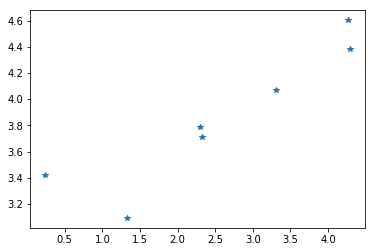

In [98]:
#Maximos 
#Correccion de maximos (tomo hasta el elemento 6, despues la amplitud decae mucho)
tMaximosA[22]
MaximosA[22]
MaximosA_corregido_22=MaximosA[22][0:7]
tMaximosA_corregido_22=tMaximosA[22][0:7]
plt.plot(tMaximosA_corregido_22,MaximosA_corregido_22,'*')
Periodo_Max_22=[]
for i in range (0,len(tMaximosA_corregido_22)-1):
    Periodo_Max_22.append(tMaximosA_corregido_22[i+1]-tMaximosA_corregido_22[i])
Periodo_Max_22
Periodo_Max_22_prom=(Periodo_Max_22[0]+Periodo_Max_22[1]+Periodo_Max_22[3]+Periodo_Max_22[4])/4

1.0020040080160322
0.9979999999999999


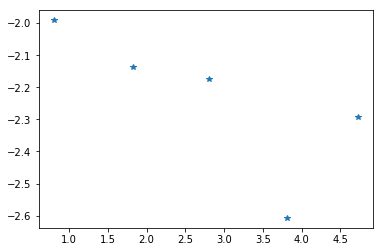

In [114]:
#Minimos 
#Correccion de minimos (tomo hasta el elemento 5, despues la amplitud aumenta mucho)
tMinimosA[22]
MinimosA[22]
MinimosA_corregido_22=MinimosA[22][0:5]
tMinimosA_corregido_22=tMinimosA[22][0:5]
plt.plot(tMinimosA_corregido_22,MinimosA_corregido_22,'*')

Periodo_Min_22=[]
for i in range (0,len(tMinimosA_corregido_22)-1):
    Periodo_Min_22.append(tMinimosA_corregido_22[i+1]-tMinimosA_corregido_22[i])
Periodo_Min_22
Periodo_Min_22_prom=(Periodo_Max_22[0]+Periodo_Max_22[1]+Periodo_Max_22[3]+Periodo_Max_22[4])/4

Periodo_prom_22=(Periodo_Min_22_prom+Periodo_Max_22_prom)/2
Frecuencia_22=1/Periodo_prom_22

print(Periodo_prom_22)
print(Frecuencia_22)

##### CilCon 25

1.0053440213760856

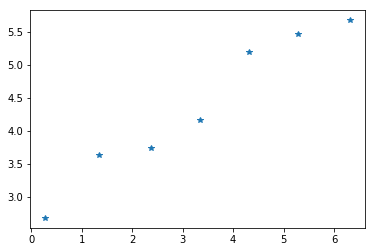

In [113]:
#Maximos 
plt.plot(tMaximosA[25],MaximosA[25],'*')
Periodo_Max_25=[]
for i in range (0,len(tMaximosA[25])-1):
    Periodo_Max_25.append(tMaximosA[25][i+1]-tMaximosA[25][i])
Periodo_Max_25
Periodo_Max_25_prom=np.mean(Periodo_Max_25)

1.0053440213760856
0.9946843853820597


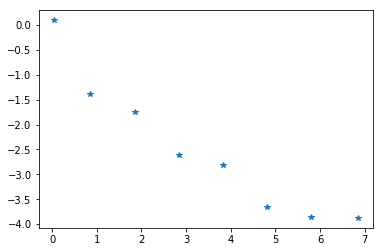

In [115]:
#Minimos 
plt.plot(tMinimosA[25],MinimosA[25],'*')

Periodo_Min_25=[]
for i in range (0,len(tMinimosA[25])-1):
    Periodo_Min_25.append(tMinimosA[25][i+1]-tMinimosA[25][i])
Periodo_Min_25
Periodo_Min_25_prom=np.mean(Periodo_Max_25)

Periodo_prom_25=(Periodo_Min_25_prom+Periodo_Max_25_prom)/2
Frecuencia_25=1/Periodo_prom_25

print(Periodo_prom_25)
print(Frecuencia_25)

##### CilCon 26

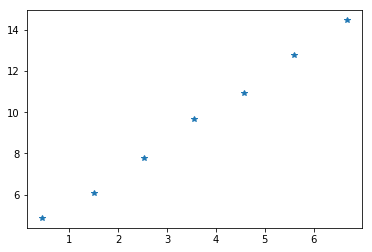

In [121]:
#Maximos 
plt.plot(tMaximosA[26],MaximosA[26],'*')
Periodo_Max_26=[]
for i in range (0,len(tMaximosA[26])-1):
    Periodo_Max_26.append(tMaximosA[26][i+1]-tMaximosA[26][i])
Periodo_Max_26
Periodo_Max_26_prom=np.mean(Periodo_Max_26)

1.0387441549766199
0.9627009646302251


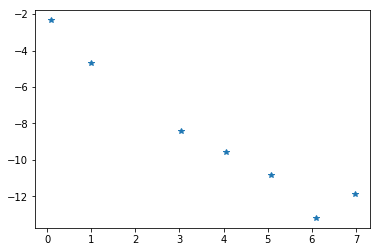

In [118]:
#Minimos 
plt.plot(tMinimosA[26],MinimosA[26],'*')

Periodo_Min_26=[]
for i in range (0,len(tMinimosA[26])-1):
    Periodo_Min_26.append(tMinimosA[26][i+1]-tMinimosA[26][i])
Periodo_Min_26
Periodo_Min_26_prom=np.mean(Periodo_Max_26)

Periodo_prom_26=(Periodo_Min_26_prom+Periodo_Max_26_prom)/2
Frecuencia_26=1/Periodo_prom_26

print(Periodo_prom_26)
print(Frecuencia_26)

##### CilCon 29

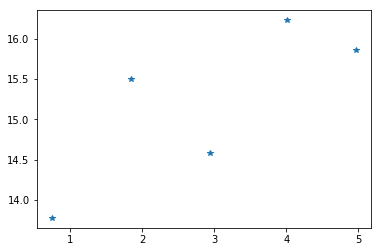

In [130]:
#Maximos
#Correccion de maximos (tomo desde el elemento 2)
MaximosA_corregido_29=MaximosA[29][1:6]
tMaximosA_corregido_29=tMaximosA[29][1:6]
plt.plot(tMaximosA_corregido_29,MaximosA_corregido_29,'*')
Periodo_Max_29=[]
for i in range (0,len(tMaximosA_corregido_29)-1):
    Periodo_Max_29.append(tMaximosA_corregido_29[i+1]-tMaximosA_corregido_29[i])
Periodo_Max_29_prom=np.mean(Periodo_Max_29)

1.0796593186372745
0.9262180974477959


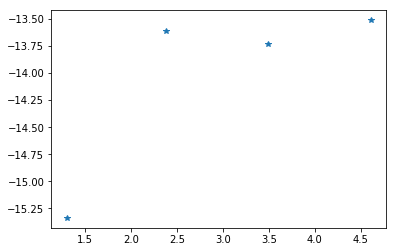

In [133]:
#Minimos 
#Correccion de minimos (tomo desde el elemento 3)
MinimosA_corregido_29=MinimosA[29][2:6]
tMinimosA_corregido_29=tMinimosA[29][2:6]
plt.plot(tMinimosA_corregido_29,MinimosA_corregido_29,'*')

Periodo_Min_29=[]
for i in range (0,len(tMinimosA_corregido_29)-1):
    Periodo_Min_29.append(tMinimosA_corregido_29[i+1]-tMinimosA_corregido_29[i])
Periodo_Min_29_prom=np.mean(Periodo_Min_29)

Periodo_prom_29=(Periodo_Min_29_prom+Periodo_Max_29_prom)/2
Frecuencia_29=1/Periodo_prom_29

print(Periodo_prom_29)
print(Frecuencia_29)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------

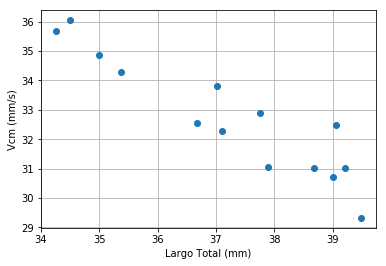

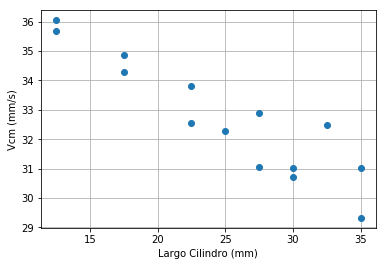

In [37]:
Velocidades=[]
LargosTot=[]
LargosCil=[]

for i in [1,2,3,4,5,6,7,8,9,10,12,13,14,15]:
    Velocidades.append(-np.asarray(VCM[i]))
    LargosTot.append(Ltot[i])
    LargosCil.append(Lcil[i])
plt.figure(1)
plt.plot(LargosTot,Velocidades,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(LargosCil,Velocidades,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')

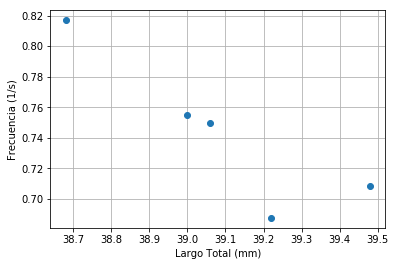

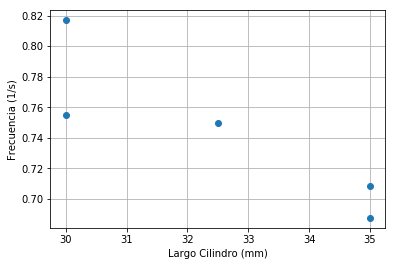

In [38]:
frecuenciasA = []
Lc = []
LT = []
for i in [1,2,9,10,15]:
    Lc.append(Lcil[i])
    LT.append(Ltot[i])
    PeriodoAm = []
    PeriodoAM = []
    for j in range(len(tMaximosA[i][1:-1])-1):
        PeriodoAM.append(tMaximosA[i][j+2]-tMaximosA[i][j+1])
    PerM = np.mean(PeriodoAM)
    for j in range(len(tMinimosA[i][1:-1])-1):
        PeriodoAm.append(tMinimosA[i][j+2]-tMinimosA[i][j+1])
    Perm = np.mean(PeriodoAm)
    TA[i]=(PerM+Perm)/2
    frecuenciasA.append(1/TA[i])    

plt.figure(1)
plt.plot(LT,frecuenciasA,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(Lc,frecuenciasA,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
    

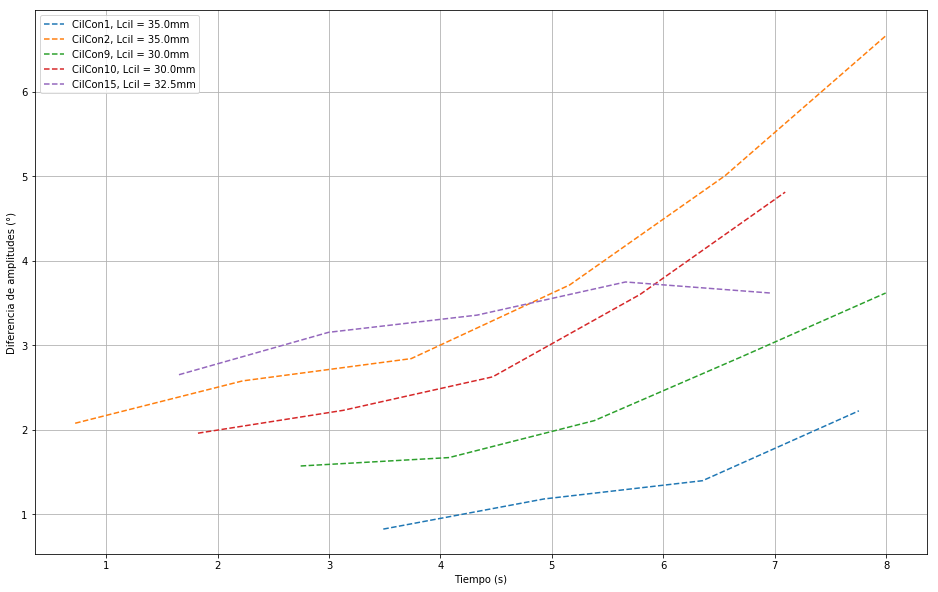

In [39]:
plt.figure(figsize=(16,10))
plt.plot((np.asarray(tMaximosA[1][1:-1])+np.asarray(tMinimosA[1][3:]))/2,(np.asarray(MaximosA[1][1:-1])-np.asarray(MinimosA[1][3:]))/2,'--',label='CilCon1, Lcil = '+str(Lcil[1])+'mm')
plt.plot((np.asarray(tMaximosA[2])+np.asarray(tMinimosA[2][1:]))/2,(np.asarray(MaximosA[2])-np.asarray(MinimosA[2][1:]))/2,'--',label='CilCon2, Lcil = '+str(Lcil[2])+'mm')
plt.plot((np.asarray(tMaximosA[9][2:])+np.asarray(tMinimosA[9][2:]))/2,(np.asarray(MaximosA[9][2:])-np.asarray(MinimosA[9][2:]))/2,'--',label='CilCon9, Lcil = '+str(Lcil[9])+'mm')
plt.plot((np.asarray(tMaximosA[10][:-1])+np.asarray(tMinimosA[10][2:-2]))/2,(np.asarray(MaximosA[10][:-1])-np.asarray(MinimosA[10][2:-2]))/2,'--',label='CilCon10, Lcil = '+str(Lcil[10])+'mm')
plt.plot((np.asarray(tMaximosA[15][1:-1])+np.asarray(tMinimosA[15][1:]))/2,(np.asarray(MaximosA[15][1:-1])-np.asarray(MinimosA[15][1:]))/2,'--',label='CilCon15, Lcil = '+str(Lcil[15])+'mm')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Diferencia de amplitudes (°)')
plt.grid(b=True, which='major')

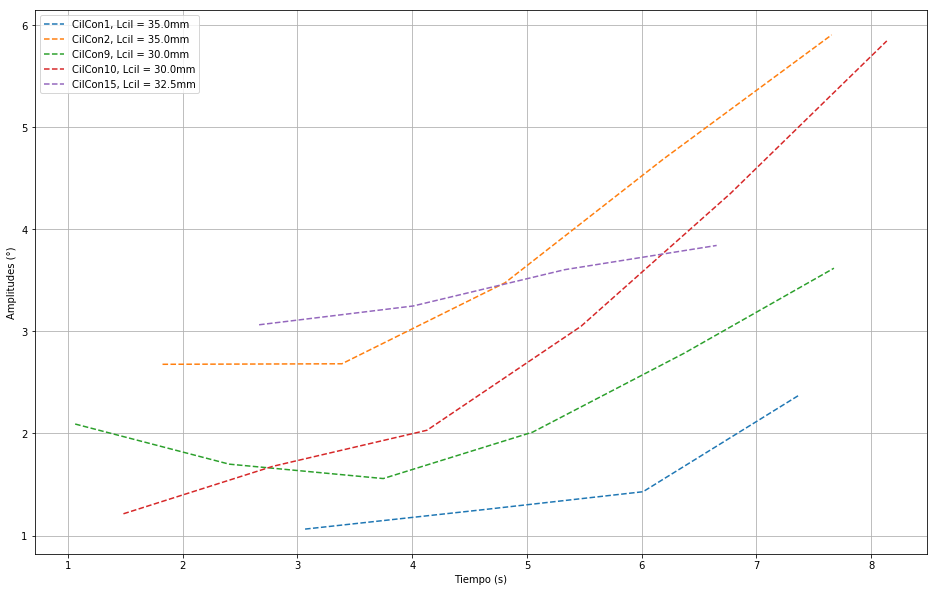

In [40]:
plt.figure(figsize=(16,10))
plt.plot(tMaximosA[1][1:-1],MaximosA[1][1:-1],'--',label='CilCon1, Lcil = '+str(Lcil[1])+'mm')
plt.plot(tMaximosA[2][1:],MaximosA[2][1:],'--',label='CilCon2, Lcil = '+str(Lcil[2])+'mm')
plt.plot(tMaximosA[9][1:],MaximosA[9][1:],'--',label='CilCon9, Lcil = '+str(Lcil[9])+'mm')
plt.plot(tMaximosA[10],MaximosA[10],'--',label='CilCon10, Lcil = '+str(Lcil[10])+'mm')
plt.plot(tMaximosA[15][2:-1],MaximosA[15][2:-1],'--',label='CilCon15, Lcil = '+str(Lcil[15])+'mm')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitudes (°)')
plt.grid(b=True, which='major')

### Con Raros

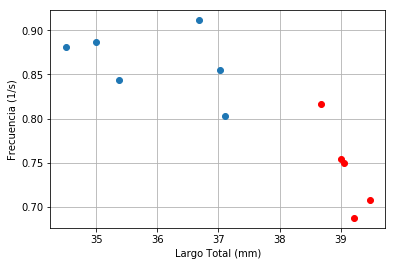

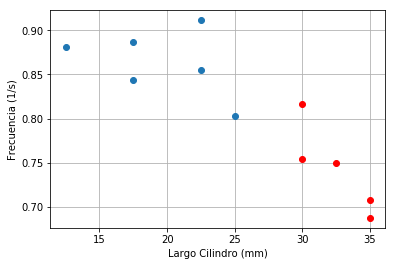

In [41]:
frecuenciasAR = []
LcR = []
LTR= []
for i in [3,4,5,12,13,14]:
    LcR.append(Lcil[i])
    LTR.append(Ltot[i])
    frecuenciasAR.append(1/TA[i])    

plt.figure(1)
plt.plot(LT,frecuenciasA,'ro')
plt.plot(LTR,frecuenciasAR,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(Lc,frecuenciasA,'ro')
plt.plot(LcR,frecuenciasAR,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')